In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import InterpolationMode
from torch import amp
from torch import optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_transforms = T.Compose([
    T.Resize(340, interpolation=InterpolationMode.BICUBIC),
    T.RandomResizedCrop(300, scale=(0.8, 1.0), interpolation=InterpolationMode.BICUBIC),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    T.ColorJitter(0.2, 0.2, 0.1),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.25, scale=(0.02, 0.08), ratio=(0.3, 3.3)),
])

val_transforms = T.Compose([
    T.Resize(340, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(300),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [4]:
train_dataset_raw = ImageFolder(root="skin-lesions/train")
train_dataset = ImageFolder(root="skin-lesions/train", transform=train_transforms)
valid_dataset = ImageFolder(root="skin-lesions/valid", transform=val_transforms)
test_dataset  = ImageFolder(root="skin-lesions/test", transform=val_transforms)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

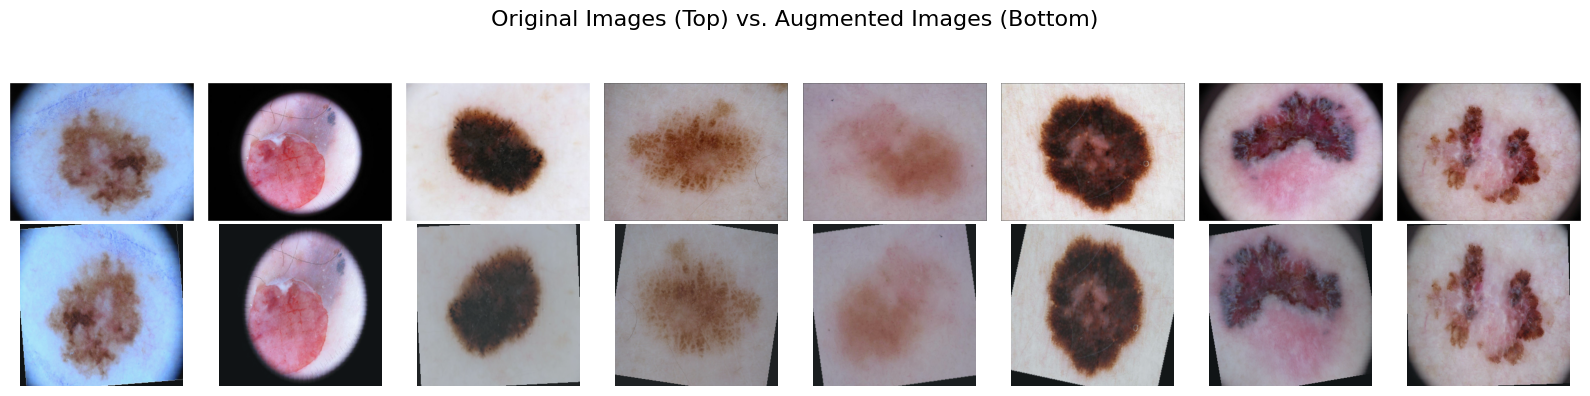

In [5]:
# Class names from the dataset
classes = train_dataset.classes

def unnormalize(img_tensor):
    # Convert normalized tensor back to image for display
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def show_augmented_vs_original(transform, dataset, num_images=8):
    # Get original images (PIL) from dataset
    original_images = [dataset[i][0] for i in range(num_images)]

    # Apply augmentations
    augmented_images = [transform(img) for img in original_images]

    fig, axs = plt.subplots(2, num_images, figsize=(16, 4))
    fig.suptitle('Original Images (Top) vs. Augmented Images (Bottom)', fontsize=16)

    for i in range(num_images):
        # Display original images
        axs[0, i].imshow(original_images[i])
        axs[0, i].axis('off')
        if i == 0:
            axs[0, i].set_ylabel('Original', fontsize=12)

        # Display augmented images (unnormalized tensor)
        img = unnormalize(augmented_images[i])
        axs[1, i].imshow(img)
        axs[1, i].axis('off')
        if i == 0:
            axs[1, i].set_ylabel('Augmented', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# To use this function, pass your transform pipeline and the raw dataset without transforms:
show_augmented_vs_original(transform=train_transforms, dataset=train_dataset_raw)

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch import amp
from torch import optim

num_classes = len(train_dataset.classes)

# 1) cargar con pesos de ImageNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# 2) reemplazar la fc para tus 3 clases (ajusta si son otras)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [7]:
# congelar todo excepto la capa final
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
epochs_head = 6  # 2–5 épocas suelen bastar
use_amp = True


scaler = amp.GradScaler(device="cuda")

def run_epoch(loader, train=True):
    model.train(mode=train)
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train: optimizer.zero_grad(set_to_none=True)

        ctx = amp.autocast(device_type="cuda")
        with ctx:
            out  = model(x)
            loss = criterion(out, y)
        if train:
            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        loss_sum += loss.item() * y.size(0)
        _, pred = out.max(1)
        total += y.size(0)
        correct += (pred == y).sum().item()
    return loss_sum/max(total,1), 100.0*correct/max(total,1)

# nullcontext helper
from contextlib import nullcontext

best_val = 0.0
for ep in range(epochs_head):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader,   False)
    print(f"[Head] Ep {ep+1}/{epochs_head} | Train {tr_loss:.4f}/{tr_acc:.2f}% | Val {va_loss:.4f}/{va_acc:.2f}%")
    if va_acc > best_val:
        best_val = va_acc
        torch.save(model.state_dict(), "resnet18_head_best.pth")


[Head] Ep 1/6 | Train 0.8058/67.25% | Val nan/56.00%
[Head] Ep 2/6 | Train 0.7266/69.85% | Val nan/63.33%
[Head] Ep 3/6 | Train 0.6937/70.10% | Val nan/61.33%
[Head] Ep 4/6 | Train 0.6949/70.60% | Val nan/66.00%
[Head] Ep 5/6 | Train 0.6513/72.65% | Val nan/62.00%
[Head] Ep 6/6 | Train 0.6469/73.00% | Val nan/58.00%


In [8]:
# descongelar todo el backbone
for p in model.parameters():
    p.requires_grad = True

# LR más bajo para no destruir los pesos preentrenados
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
epochs_ft = 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs_ft)

for ep in range(epochs_ft):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    scheduler.step()  # después del optimizer.step() que ocurre en run_epoch
    va_loss, va_acc = run_epoch(val_loader,   False)
    print(f"[FT ] Ep {ep+1}/{epochs_ft} | Train {tr_loss:.4f}/{tr_acc:.2f}% | Val {va_loss:.4f}/{va_acc:.2f}%")
    if va_acc > best_val:
        best_val = va_acc
        torch.save(model.state_dict(), "resnet18_finetune_best.pth")


[FT ] Ep 1/10 | Train 0.6706/72.75% | Val nan/68.67%
[FT ] Ep 2/10 | Train 0.5416/77.50% | Val nan/68.67%
[FT ] Ep 3/10 | Train 0.4598/82.40% | Val nan/69.33%
[FT ] Ep 4/10 | Train 0.3628/85.05% | Val nan/74.67%
[FT ] Ep 5/10 | Train 0.3002/88.40% | Val nan/71.33%
[FT ] Ep 6/10 | Train 0.2427/89.70% | Val nan/72.00%
[FT ] Ep 7/10 | Train 0.1694/93.95% | Val nan/73.33%
[FT ] Ep 8/10 | Train 0.1555/94.40% | Val nan/74.00%
[FT ] Ep 9/10 | Train 0.1161/96.30% | Val nan/75.33%
[FT ] Ep 10/10 | Train 0.0968/96.50% | Val nan/74.00%


In [9]:
# cargar el mejor
model.load_state_dict(torch.load("resnet18_finetune_best.pth", map_location=device))
model.eval()

correct, total, loss_sum = 0, 0, 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss_sum += criterion(out, y).item() * y.size(0)
        _, pred = out.max(1)
        total += y.size(0)
        correct += (pred == y).sum().item()

print(f"Test Loss: {loss_sum/total:.4f} | Test Acc: {100.0*correct/total:.2f}%")


Test Loss: 0.6370 | Test Acc: 78.17%


In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
from pathlib import Path
import pandas as pd
CLASS_NAMES = ["melanoma", "nevus", "seborrheic_keratosis"]  # columnas deseadas
MODEL_PATH = "resnet18_finetune_best.pth"


# --- Cargar arquitectura base ---
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 clases: melanoma, nevus, seborrheic_keratosis

# --- Cargar los pesos entrenados ---
state_dict = torch.load("resnet18_finetune_best.pth", map_location=device)
model.load_state_dict(state_dict)

# --- Preparar para inferencia ---
model.to(device)
model.eval()
print("✅ Modelo cargado correctamente en", device)
# --- Inferencia ---
softmax = nn.Softmax(dim=1)
rows = []

with torch.no_grad():
    for imgs, _ in test_loader:   # <- usa tu DataLoader existente
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs)
        probs = softmax(logits).cpu().numpy()

        # Recuperar los nombres de archivo desde test_dataset.samples
        start = len(rows)
        end = start + probs.shape[0]
        batch_samples = test_dataset.samples[start:end]

        for (path, _), p in zip(batch_samples, probs):
            img_id = Path(path).stem
            rows.append({
                "Id": img_id+".jpg",
                CLASS_NAMES[0]: float(p[0]),
                CLASS_NAMES[1]: float(p[1]),
                CLASS_NAMES[2]: float(p[2]),
            })

# --- Guardar CSV ---
df = pd.DataFrame(rows, columns=["Id"] + CLASS_NAMES)
df = df.sort_values("Id").reset_index(drop=True)
df.to_csv("submission.csv", index=False)

print("✅ Listo: submission1.csv guardado")
print(df.head())

c:\Users\flavi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\flavi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Modelo cargado correctamente en cuda
✅ Listo: submission1.csv guardado
                 Id  melanoma     nevus  seborrheic_keratosis
0  ISIC_0012086.jpg  0.354956  0.098224              0.546820
1  ISIC_0012092.jpg  0.066657  0.932748              0.000595
2  ISIC_0012095.jpg  0.005371  0.993597              0.001032
3  ISIC_0012134.jpg  0.000023  0.025639              0.974338
4  ISIC_0012136.jpg  0.002126  0.750319              0.247555
